# Rough project/code architecture

1. Load MNIST into some kind of native dataformat (i.e. not with a oneliner that gives you a pytorch dataset)
1. Load entire MNIST into a dataset, then make that into a dataloader
1. Train MNIST with pytorch.  make a note of loss and accuracy. You’ll need to choose an architecture, batch size and number of epochs to train for. 
    * Get architecture from pytorch docs. Should be simple. 
    * Number of epochs is “until results get as good as they are going to get”, i.e. by inspection.
    * Batch size I got no idea. 1 is probably fine, but feel free to try others.
1. Split MNIST into N groups randomly. Create N datasets. Train with federated.py. You should get roughly the final loss and accuracy you saw previously. 
    * Use the same architecture as before.
    * Choose number of rounds same way you chose number of epochs in previous step, i.e. until it converges.
    * Number of epochs per round. Maybe try 1, 5 and 10? Go with 1 unless you get very different results.
    * Batch size should probably be the same as before.
1. Repeat, but split MNIST into N groups with the deck stacked (possibly as extremely as 10 groups each containing data from only one class).

### Snippets

#### Visualize an array
See cell 109 here: https://github.com/williamsmj/pytorch-notes/blob/master/pytorch-60-minute-blitz.ipynb

#### Change native data to dataset, change dataset to native data, and loop over dataset doing something other than training
See https://github.com/williamsmj/pytorch-notes/blob/master/dataset_manipulation.ipynb 


In [1]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [2]:
import torch
import torchvision.datasets as dsets

import torchvision.transforms as transforms
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])

# pytorch datasets that download MNIST set as needed; used only to download files
train_dset = dsets.MNIST(root=data_path, download=False, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=False, train=False, transform=trans)

#print("Training dset:", train_dset)
#print("Test dset:", test_dset)

In [3]:
torch.__version__

'0.4.1'

In [4]:
# Load MNIST data into numpy arrays
import numpy as np
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
# read data and label files into numpy arrays
test_data = read_idx(test_data_file)
test_labels = read_idx(test_labels_file)
train_data = read_idx(train_data_file)
train_labels = read_idx(train_labels_file)

In [5]:
# save CSV files if needed

"""
np.savetxt("./MNIST-data/raw/test_data.csv", test_data.reshape(len(test_data), 784), delimiter=',')
np.savetxt("./MNIST-data/raw/test_labels.csv", test_labels, delimiter=',')
np.savetxt("./MNIST-data/raw/train_data.csv", train_data.reshape(len(train_data), 784), delimiter=',')
np.savetxt("./MNIST-data/raw/train_labels.csv", train_labels, delimiter=',')

"""

# to restore
#np.loadtext()
#reshape((len(), 28, 28))

'\nnp.savetxt("./MNIST-data/raw/test_data.csv", test_data.reshape(len(test_data), 784), delimiter=\',\')\nnp.savetxt("./MNIST-data/raw/test_labels.csv", test_labels, delimiter=\',\')\nnp.savetxt("./MNIST-data/raw/train_data.csv", train_data.reshape(len(train_data), 784), delimiter=\',\')\nnp.savetxt("./MNIST-data/raw/train_labels.csv", train_labels, delimiter=\',\')\n\n'

In [6]:
# Take a look at the data in the arrays

"""
# pick a random sample from the sets of observations
import random
test_sample_num = random.randint(0, len(test_labels))
train_sample_num = random.randint(0, len(train_labels))

# print some arrays to confirm we have data
print("Test labels:", test_labels)
print("Test data:", test_data[test_sample_num])
print("Training labels:", train_labels)
print("Training data:", train_data[train_sample_num])
"""

'\n# pick a random sample from the sets of observations\nimport random\ntest_sample_num = random.randint(0, len(test_labels))\ntrain_sample_num = random.randint(0, len(train_labels))\n\n# print some arrays to confirm we have data\nprint("Test labels:", test_labels)\nprint("Test data:", test_data[test_sample_num])\nprint("Training labels:", train_labels)\nprint("Training data:", train_data[train_sample_num])\n'

In [7]:
# visualize some test samples

"""
import matplotlib.pyplot as plt
%matplotlib inline

img = test_data[test_sample_num]
label = test_labels[test_sample_num]
print('Test sample index: ', test_sample_num)
print('Sample value: ', label)
plt.imshow(img)
"""

"\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nimg = test_data[test_sample_num]\nlabel = test_labels[test_sample_num]\nprint('Test sample index: ', test_sample_num)\nprint('Sample value: ', label)\nplt.imshow(img)\n"

In [8]:
# how is the test data distributed?

"""
print('Test sample histogram:')
plt.hist(test_labels, bins=10)
"""

"\nprint('Test sample histogram:')\nplt.hist(test_labels, bins=10)\n"

In [9]:
# visualize a training sample

"""
img = train_data[train_sample_num]
label = train_labels[train_sample_num]
print('Training sample index: ', train_sample_num)
print('Sample value: ', label)
plt.imshow(img)
"""

"\nimg = train_data[train_sample_num]\nlabel = train_labels[train_sample_num]\nprint('Training sample index: ', train_sample_num)\nprint('Sample value: ', label)\nplt.imshow(img)\n"

In [10]:
# how is the training data distributed?

"""
print('Training data histogram:')
plt.hist(train_labels, bins=10)
"""

"\nprint('Training data histogram:')\nplt.hist(train_labels, bins=10)\n"

In [11]:
# load numpy arrays into pytorch Datasets
import torch
from torch.utils.data import TensorDataset

# create tensors from np arrays
test_data_tensor = torch.from_numpy(test_data)
test_labels_tensor = torch.from_numpy(test_labels)
train_data_tensor = torch.from_numpy(train_data)
train_labels_tensor = torch.from_numpy(train_labels)


# TODO: TRANSFORM THE DATA WHEN THE SETS ARE CREATED
"""
import torch
import torchvision.datasets as dsets

import torchvision.transforms as transforms
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
"""

# load tensors into datasets
test_dset = TensorDataset(test_data_tensor, test_labels_tensor, transform=trans)
train_dset = TensorDataset(train_data_tensor, train_labels_tensor, transform=trans)

print("test_dset:",
      test_dset,
      len(test_dset), test_dset[0][0].size(), type(test_dset[0][0])
     )


TypeError: __init__() got an unexpected keyword argument 'transform'

In [12]:
from torch.utils.data import DataLoader

# create dataloaders
batch_size = 1
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)

print("test_dloader", len(test_dloader),
     )

test_dloader 10000


In [13]:
# set up network

import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## network
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

==>>> epoch: 0, batch index: 2000, train loss: 2.258546
==>>> epoch: 0, batch index: 4000, train loss: 2.162534
==>>> epoch: 0, batch index: 6000, train loss: 1.975261
==>>> epoch: 0, batch index: 8000, train loss: 1.690423
==>>> epoch: 0, batch index: 10000, train loss: 1.239327
==>>> epoch: 0, batch index: 12000, train loss: 0.952410
==>>> epoch: 0, batch index: 14000, train loss: 0.702495
==>>> epoch: 0, batch index: 16000, train loss: 0.687791
==>>> epoch: 0, batch index: 18000, train loss: 0.598707
==>>> epoch: 0, batch index: 20000, train loss: 0.640071
==>>> epoch: 0, batch index: 22000, train loss: 0.482804
==>>> epoch: 0, batch index: 24000, train loss: 0.615392
==>>> epoch: 0, batch index: 26000, train loss: 0.546289
==>>> epoch: 0, batch index: 28000, train loss: 0.437503
==>>> epoch: 0, batch index: 30000, train loss: 0.390828
==>>> epoch: 0, batch index: 32000, train loss: 0.476861
==>>> epoch: 0, batch index: 34000, train loss: 0.347122
==>>> epoch: 0, batch index: 36000,

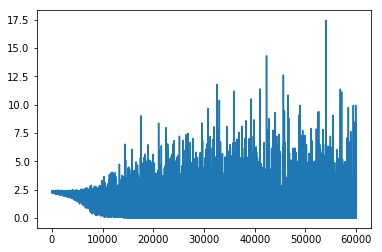

In [16]:
import torch.nn.functional as F
from torch.autograd import Variable

model = MLPNet()

learning_rate = 0.0003
momentum = 0.5
num_epochs = 1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_loss_history = []

for epoch in range(num_epochs):
    avg_loss = 0

    # train
    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        train_loss_history.append(loss.item())
        avg_loss = avg_loss * 0.99 + loss.item() * 0.01
        loss.backward()
        optimizer.step()
                    
        if (batch_idx+1) % 2000 == 0 or (batch_idx+1) == len(train_dloader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, avg_loss))

            
            



# ADD TESTING AFTER TRAINING

In [ ]:
# ADD PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_loss_history, label="train");

In [23]:
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

## training
model = LeNet()


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_loss_history = []
test_loss_history = []

for epoch in range(1):
    # training
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        train_loss_history.append(loss.item())
        ave_loss = ave_loss * 0.99 + loss.item() * 0.01
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_dloader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_dloader):
        with torch.no_grad():
            x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        test_loss_history.append(loss.item())
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.99 + loss.item() * 0.01
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_dloader):
            print ('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

==>>> epoch: 0, batch index: 100, train loss: 1.464695
==>>> epoch: 0, batch index: 200, train loss: 1.747897
==>>> epoch: 0, batch index: 300, train loss: 1.791303
==>>> epoch: 0, batch index: 400, train loss: 1.883426
==>>> epoch: 0, batch index: 500, train loss: 1.700222
==>>> epoch: 0, batch index: 600, train loss: 1.842954
==>>> epoch: 0, batch index: 700, train loss: 1.886750
==>>> epoch: 0, batch index: 800, train loss: 2.018955
==>>> epoch: 0, batch index: 900, train loss: 1.843694
==>>> epoch: 0, batch index: 1000, train loss: 1.896781
==>>> epoch: 0, batch index: 1100, train loss: 1.761072
==>>> epoch: 0, batch index: 1200, train loss: 1.853076
==>>> epoch: 0, batch index: 1300, train loss: 1.539231
==>>> epoch: 0, batch index: 1400, train loss: 1.510832
==>>> epoch: 0, batch index: 1500, train loss: 1.398014
==>>> epoch: 0, batch index: 1600, train loss: 1.803469
==>>> epoch: 0, batch index: 1700, train loss: 2.165218
==>>> epoch: 0, batch index: 1800, train loss: 2.254305
=

==>>> epoch: 0, batch index: 14700, train loss: 2.316671
==>>> epoch: 0, batch index: 14800, train loss: 2.309757
==>>> epoch: 0, batch index: 14900, train loss: 2.324306
==>>> epoch: 0, batch index: 15000, train loss: 2.311145
==>>> epoch: 0, batch index: 15100, train loss: 2.307342
==>>> epoch: 0, batch index: 15200, train loss: 2.328685
==>>> epoch: 0, batch index: 15300, train loss: 2.314320
==>>> epoch: 0, batch index: 15400, train loss: 2.300478
==>>> epoch: 0, batch index: 15500, train loss: 2.320795
==>>> epoch: 0, batch index: 15600, train loss: 2.325919
==>>> epoch: 0, batch index: 15700, train loss: 2.326250
==>>> epoch: 0, batch index: 15800, train loss: 2.331537
==>>> epoch: 0, batch index: 15900, train loss: 2.336182
==>>> epoch: 0, batch index: 16000, train loss: 2.322068
==>>> epoch: 0, batch index: 16100, train loss: 2.333179
==>>> epoch: 0, batch index: 16200, train loss: 2.328012
==>>> epoch: 0, batch index: 16300, train loss: 2.331956
==>>> epoch: 0, batch index: 16

==>>> epoch: 0, batch index: 29100, train loss: 2.314239
==>>> epoch: 0, batch index: 29200, train loss: 2.309528
==>>> epoch: 0, batch index: 29300, train loss: 2.307035
==>>> epoch: 0, batch index: 29400, train loss: 2.323896
==>>> epoch: 0, batch index: 29500, train loss: 2.326598
==>>> epoch: 0, batch index: 29600, train loss: 2.329159
==>>> epoch: 0, batch index: 29700, train loss: 2.320279
==>>> epoch: 0, batch index: 29800, train loss: 2.336527
==>>> epoch: 0, batch index: 29900, train loss: 2.343784
==>>> epoch: 0, batch index: 30000, train loss: 2.335966
==>>> epoch: 0, batch index: 30100, train loss: 2.338518
==>>> epoch: 0, batch index: 30200, train loss: 2.331431
==>>> epoch: 0, batch index: 30300, train loss: 2.339263
==>>> epoch: 0, batch index: 30400, train loss: 2.334477
==>>> epoch: 0, batch index: 30500, train loss: 2.319819
==>>> epoch: 0, batch index: 30600, train loss: 2.327896
==>>> epoch: 0, batch index: 30700, train loss: 2.333983
==>>> epoch: 0, batch index: 30

==>>> epoch: 0, batch index: 43500, train loss: 2.335743
==>>> epoch: 0, batch index: 43600, train loss: 2.334287
==>>> epoch: 0, batch index: 43700, train loss: 2.326617
==>>> epoch: 0, batch index: 43800, train loss: 2.326769
==>>> epoch: 0, batch index: 43900, train loss: 2.319739
==>>> epoch: 0, batch index: 44000, train loss: 2.319224
==>>> epoch: 0, batch index: 44100, train loss: 2.295642
==>>> epoch: 0, batch index: 44200, train loss: 2.341585
==>>> epoch: 0, batch index: 44300, train loss: 2.327471
==>>> epoch: 0, batch index: 44400, train loss: 2.317720
==>>> epoch: 0, batch index: 44500, train loss: 2.311874
==>>> epoch: 0, batch index: 44600, train loss: 2.323528
==>>> epoch: 0, batch index: 44700, train loss: 2.304475
==>>> epoch: 0, batch index: 44800, train loss: 2.316072
==>>> epoch: 0, batch index: 44900, train loss: 2.310189
==>>> epoch: 0, batch index: 45000, train loss: 2.334901
==>>> epoch: 0, batch index: 45100, train loss: 2.333777
==>>> epoch: 0, batch index: 45

==>>> epoch: 0, batch index: 57900, train loss: 2.298194
==>>> epoch: 0, batch index: 58000, train loss: 2.319130
==>>> epoch: 0, batch index: 58100, train loss: 2.337333
==>>> epoch: 0, batch index: 58200, train loss: 2.322055
==>>> epoch: 0, batch index: 58300, train loss: 2.331386
==>>> epoch: 0, batch index: 58400, train loss: 2.309884
==>>> epoch: 0, batch index: 58500, train loss: 2.312867
==>>> epoch: 0, batch index: 58600, train loss: 2.320931
==>>> epoch: 0, batch index: 58700, train loss: 2.315152
==>>> epoch: 0, batch index: 58800, train loss: 2.312148
==>>> epoch: 0, batch index: 58900, train loss: 2.329104
==>>> epoch: 0, batch index: 59000, train loss: 2.311904
==>>> epoch: 0, batch index: 59100, train loss: 2.337870
==>>> epoch: 0, batch index: 59200, train loss: 2.311359
==>>> epoch: 0, batch index: 59300, train loss: 2.298635
==>>> epoch: 0, batch index: 59400, train loss: 2.323130
==>>> epoch: 0, batch index: 59500, train loss: 2.330997
==>>> epoch: 0, batch index: 59

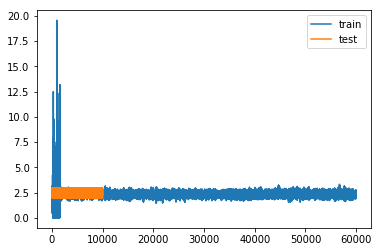

In [24]:
            
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_loss_history, label="train");
ax.plot(test_loss_history, label="test");
ax.legend();